# Libraries import

In [1]:
# --- Imports Standards ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import requests
import io
from scipy.stats import pearsonr


# L'algo concurrent (L1)
from oasis.functions import deconvolve

# Configuration visuelle
plt.rcParams['figure.figsize'] = [15, 6]
import warnings
warnings.filterwarnings('ignore') # Pour garder le notebook propre

print("Bibliothèques importées avec succès.")

Bibliothèques importées avec succès.


/opt/anaconda3/envs/TS_project/lib/python3.9/site-packages/oasis/functions.py:13: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  warn("Could not find cvxpy. Don't worry, you can still use OASIS, " +


# Data Preprocessing

In [2]:
train_calcium_path = "/Users/samuel/Desktop/Studies/MVA/Times series/Projet/FastLZeroSpikeInference/python/FastLZeroSpikeInference/spikefinder_data/spikefinder.train/1.train.calcium.csv"
df_train_calcium = pd.read_csv(train_calcium_path)
df_train_calcium

,0,1,2,3,4,5,6,7,8,9,10
0,-0.234928,0.689186,2.578560,0.636770,-0.015140,0.819771,2.442105,0.391310,0.223523,1.557675,0.625052
1,-0.182441,0.869132,2.868601,0.596164,0.022464,0.831411,2.930201,0.490213,0.116095,1.628054,0.638718
2,-0.049257,0.949273,2.784989,0.711875,0.040028,0.877191,3.065872,0.610873,0.154437,1.479382,0.552809
3,-0.032876,0.848802,2.430735,0.940943,0.038616,0.975941,3.051014,0.714453,0.335288,1.302766,0.420998
4,-0.125313,0.665088,2.064211,1.168007,0.014035,1.156689,2.967063,0.737085,0.550485,1.234470,0.367595
...,...,...,...,...,...,...,...,...,...,...,...
71981,0.538533,0.399124,NaN,0.821013,-0.170785,1.158751,0.682918,0.148761,0.652645,NaN,0.783607
71982,0.712870,0.418369,NaN,0.838734,-0.260950,1.180239,0.313320,0.151934,0.660206,NaN,0.786171
71983,0.670323,0.356299,NaN,0.842801,-0.264011,1.228860,0.215326,0.221346,0.631483,NaN,0.687742
71984,0.355962,0.335461,NaN,0.759840,-0.186234,1.177698,0.688985,0.307233,0.545631,NaN,0.590033


In [3]:
train_spikes_path = "/Users/samuel/Desktop/Studies/MVA/Times series/Projet/FastLZeroSpikeInference/python/FastLZeroSpikeInference/spikefinder_data/spikefinder.train/1.train.spikes.csv"
df_train_spikes = pd.read_csv(train_spikes_path)
df_train_spikes


,0,1,2,3,4,5,6,7,8,9,10
0,0,0,0.0,0.0,0,0,0,0.0,0,0.0,0
1,0,0,0.0,0.0,0,1,0,0.0,0,0.0,0
2,0,0,0.0,0.0,0,0,0,0.0,0,0.0,0
3,0,0,0.0,0.0,0,1,0,0.0,0,0.0,0
4,0,0,0.0,0.0,0,0,0,0.0,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...
71981,0,0,NaN,0.0,0,0,0,0.0,0,NaN,0
71982,0,0,NaN,0.0,0,0,0,0.0,0,NaN,0
71983,0,0,NaN,0.0,0,0,0,0.0,0,NaN,0
71984,0,0,NaN,0.0,0,0,0,0.0,0,NaN,0


In [4]:
print(f" shape train_calcium: {df_train_calcium.shape}, missing values train_calcium: {df_train_calcium.isna().sum()}")
print("--------------------------------")
print(f" shape train_spikes: {df_train_spikes.shape}, missing values train_spikes: {df_train_spikes.isna().sum()}")

 shape train_calcium: (71986, 11), missing values train_calcium: 0         0
1         0
2     35993
3         1
4         0
5         0
6         0
7         1
8         0
9     12269
10        0
dtype: int64
--------------------------------
 shape train_spikes: (71986, 11), missing values train_spikes: 0         0
1         0
2     35993
3         1
4         0
5         0
6         0
7         1
8         0
9     12269
10        0
dtype: int64


We drop neural 2 and 9 and the rows where there are nan values

In [5]:
# drop columns with more than 10 nan values
df_train_calcium = df_train_calcium.dropna(axis=1, thresh=df_train_calcium.shape[0]-10)

# same for df_train_spikes
df_train_spikes = df_train_spikes.dropna(axis=1, thresh=df_train_spikes.shape[0]-10)

# drop rows with any nan values
df_train_calcium = df_train_calcium.dropna(axis=0)
df_train_spikes = df_train_spikes.dropna(axis=0)

print(f"After cleaning: shape train_calcium: {df_train_calcium.shape}, missing values train_calcium: {df_train_calcium.isna().sum()}")
print("--------------------------------")
print(f"After cleaning: shape train_spikes: {df_train_spikes.shape}, missing values train_spikes: {df_train_spikes.isna().sum()}")


After cleaning: shape train_calcium: (71985, 9), missing values train_calcium: 0     0
1     0
3     0
4     0
5     0
6     0
7     0
8     0
10    0
dtype: int64
--------------------------------
After cleaning: shape train_spikes: (71985, 9), missing values train_spikes: 0     0
1     0
3     0
4     0
5     0
6     0
7     0
8     0
10    0
dtype: int64


# Data Visualization

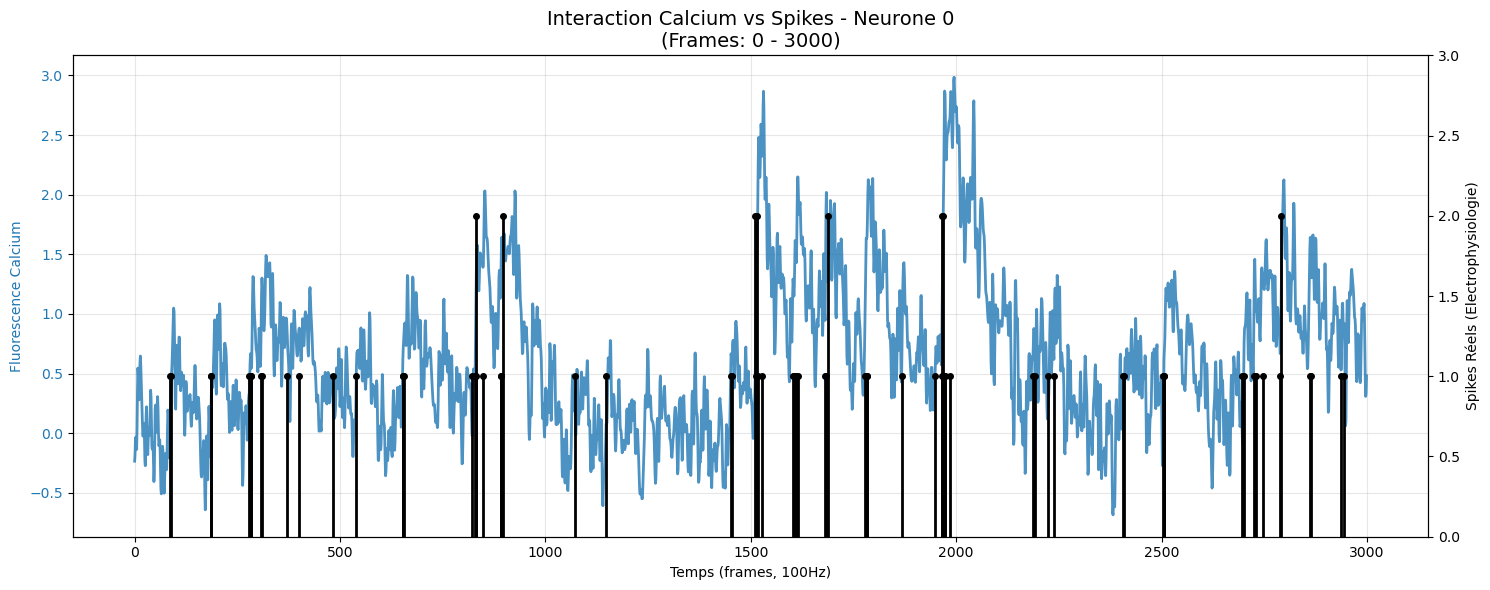

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_neuron_activity(neuron_idx, df_calcium, df_spikes, start=0, end=3000):
    """
    Plots the Calcium fluorescence vs. True Spikes for a specific neuron.
    
    Parameters:
    - neuron_idx (int): The index of the neuron to plot.
    - df_calcium (pd.DataFrame): Dataframe containing calcium data.
    - df_spikes (pd.DataFrame): Dataframe containing spike data.
    - start (int): Start frame.
    - end (int): End frame.
    """
    
    try:
        y_calcium = df_calcium.iloc[start:end, neuron_idx].values
        y_spikes = df_spikes.iloc[start:end, neuron_idx].values
    except IndexError:
        print(f"Error: Neuron index {neuron_idx} is out of bounds.")
        return

    fig, ax1 = plt.subplots(figsize=(15, 6))

    color_calc = 'tab:blue'
    ax1.set_xlabel('Temps (frames, 100Hz)')
    ax1.set_ylabel('Fluorescence Calcium', color=color_calc)
    ax1.plot(y_calcium, color=color_calc, linewidth=2, alpha=0.8, label="Calcium (Observé)")
    ax1.tick_params(axis='y', labelcolor=color_calc)
    ax1.grid(True, alpha=0.3) # Added a light grid for readability

    ax2 = ax1.twinx()
    color_spike = 'black'
    ax2.set_ylabel('Spikes Réels (Electrophysiologie)', color=color_spike)
    
    spike_times = np.where(y_spikes > 0)[0]
    spike_vals = y_spikes[spike_times]

    if len(spike_times) > 0:
        ax2.vlines(spike_times, 0, spike_vals, color='black', linewidth=2, label="Vrais Spikes")
        ax2.plot(spike_times, spike_vals, 'o', color='black', markersize=4)
        
        ax2.set_ylim(0, np.max(y_spikes) * 1.5)
    else:
        ax2.set_ylim(0, 1)

    ax2.tick_params(axis='y', labelcolor=color_spike)

    plt.title(f"Interaction Calcium vs Spikes - Neurone {neuron_idx}\n(Frames: {start} - {end})", fontsize=14)
    fig.tight_layout()
    plt.show()


plot_neuron_activity(0, df_train_calcium, df_train_spikes)

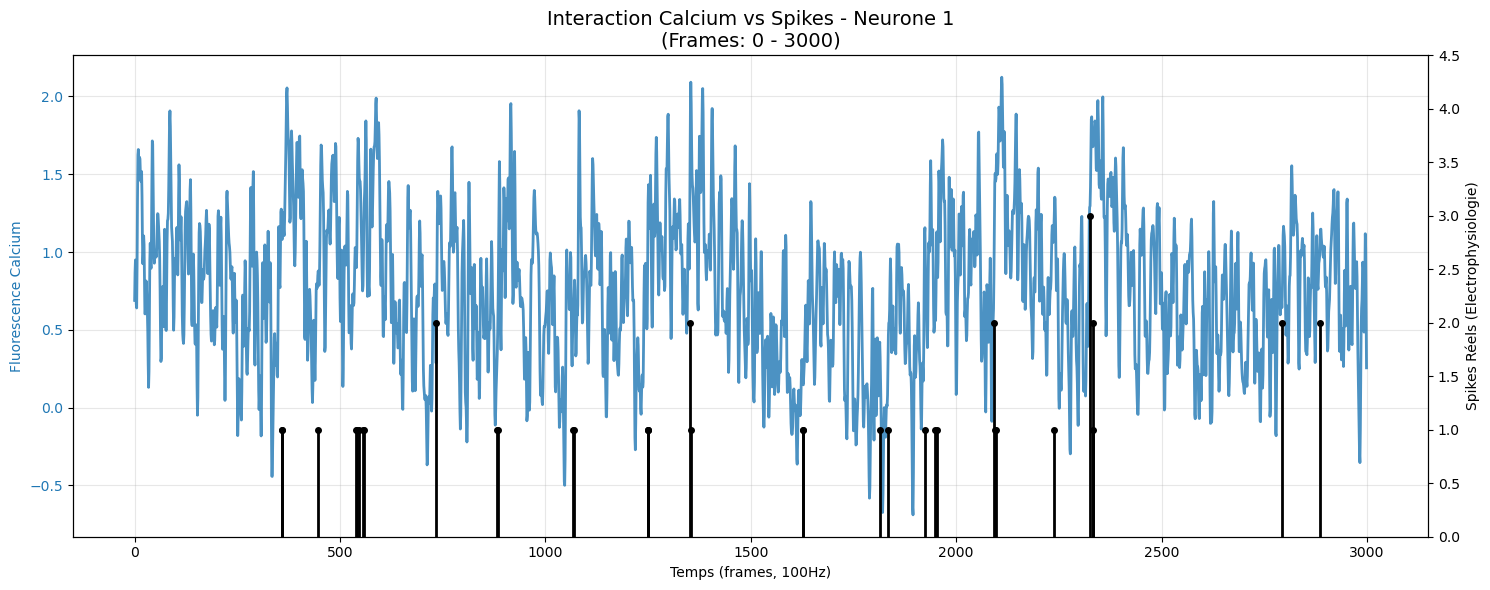

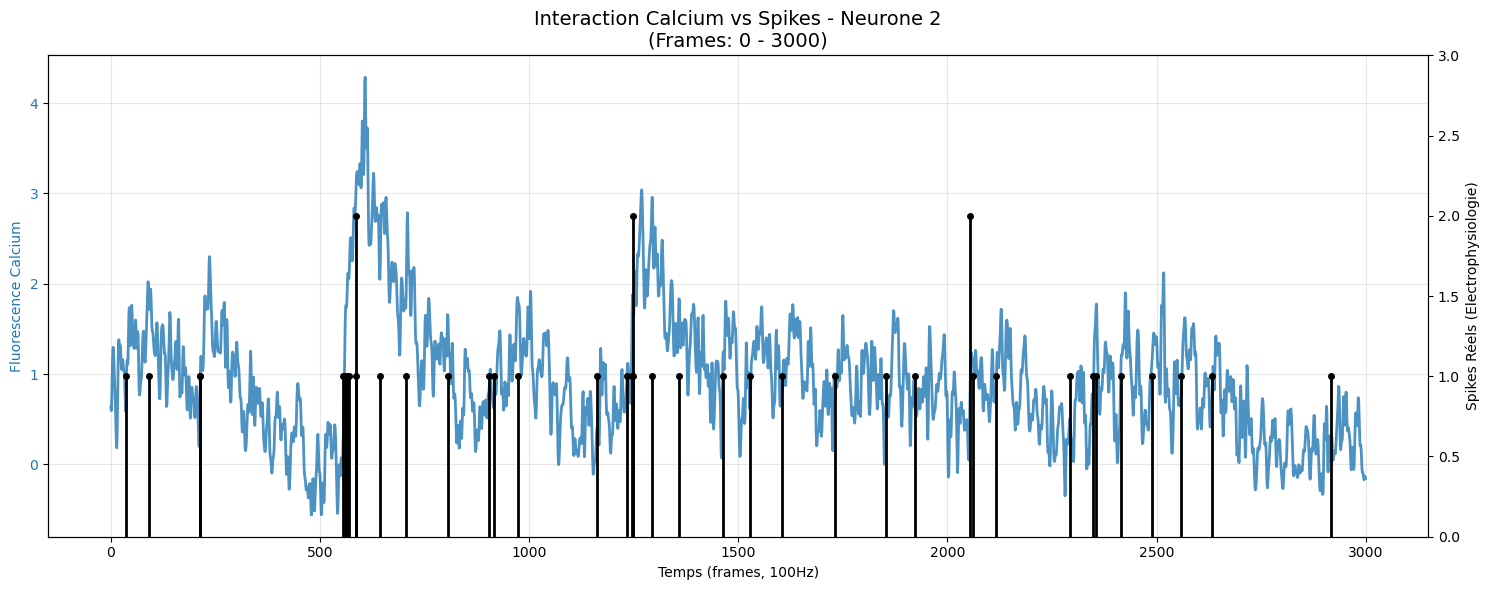

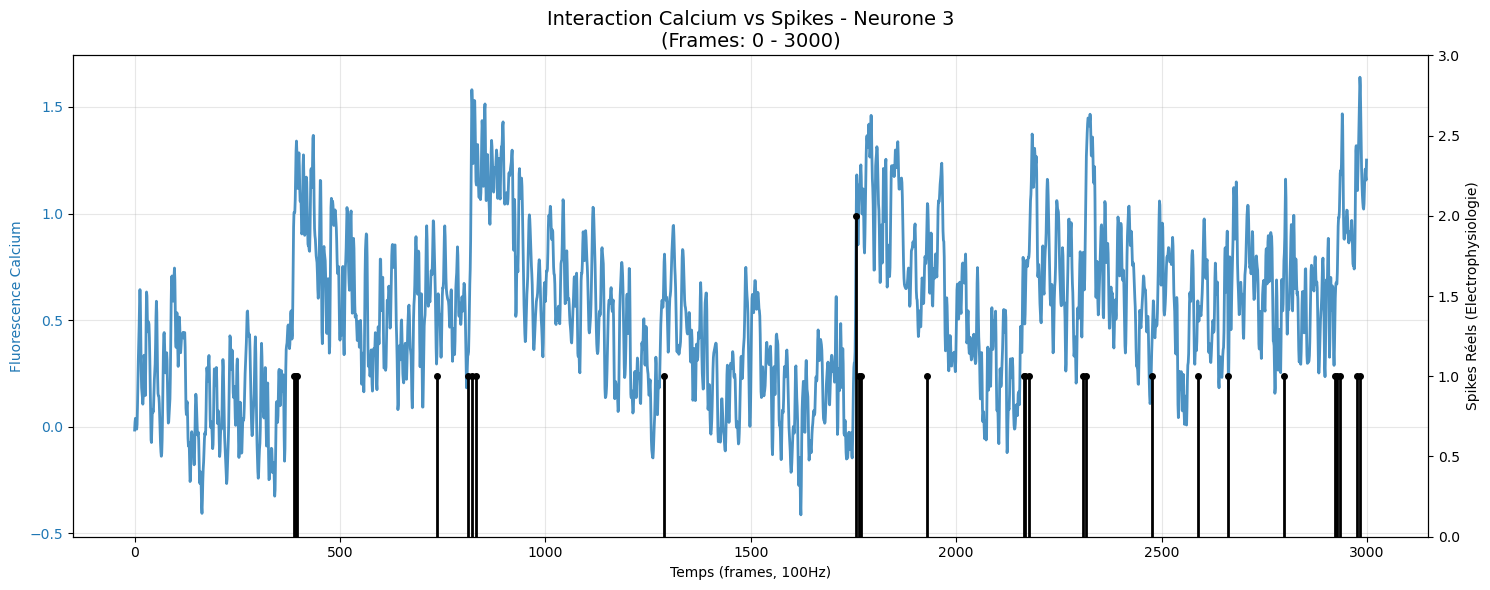

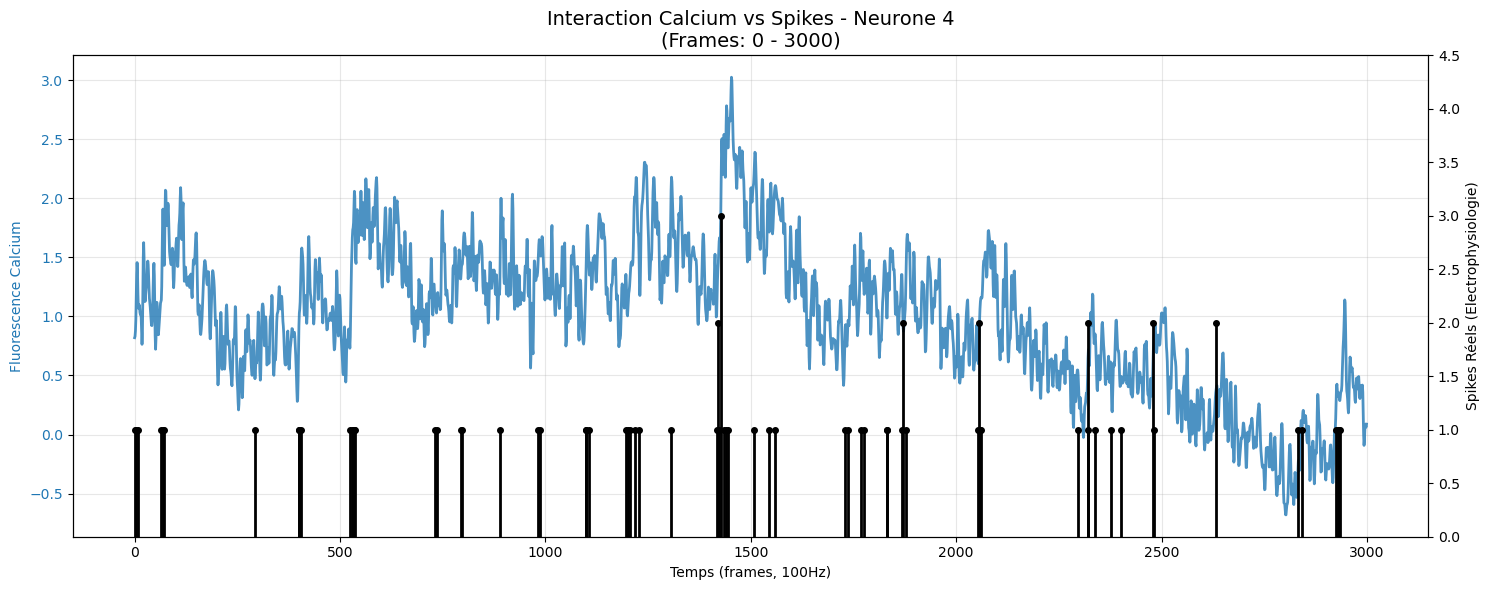

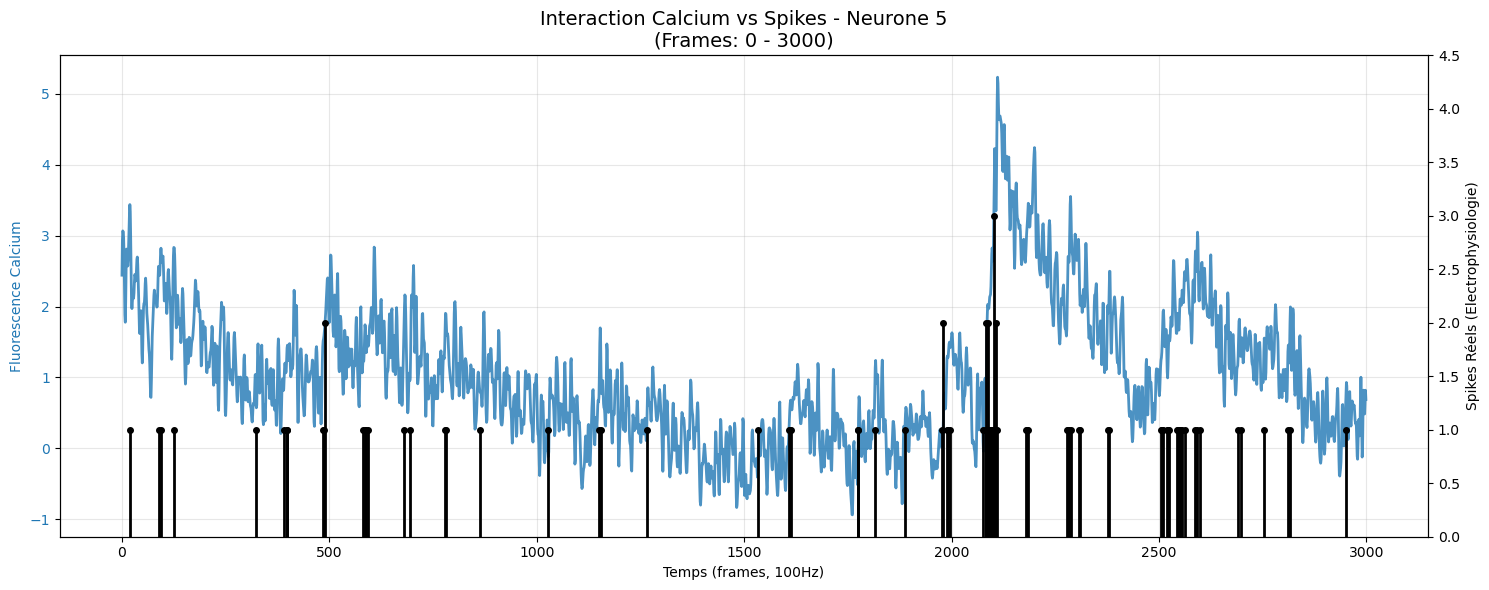

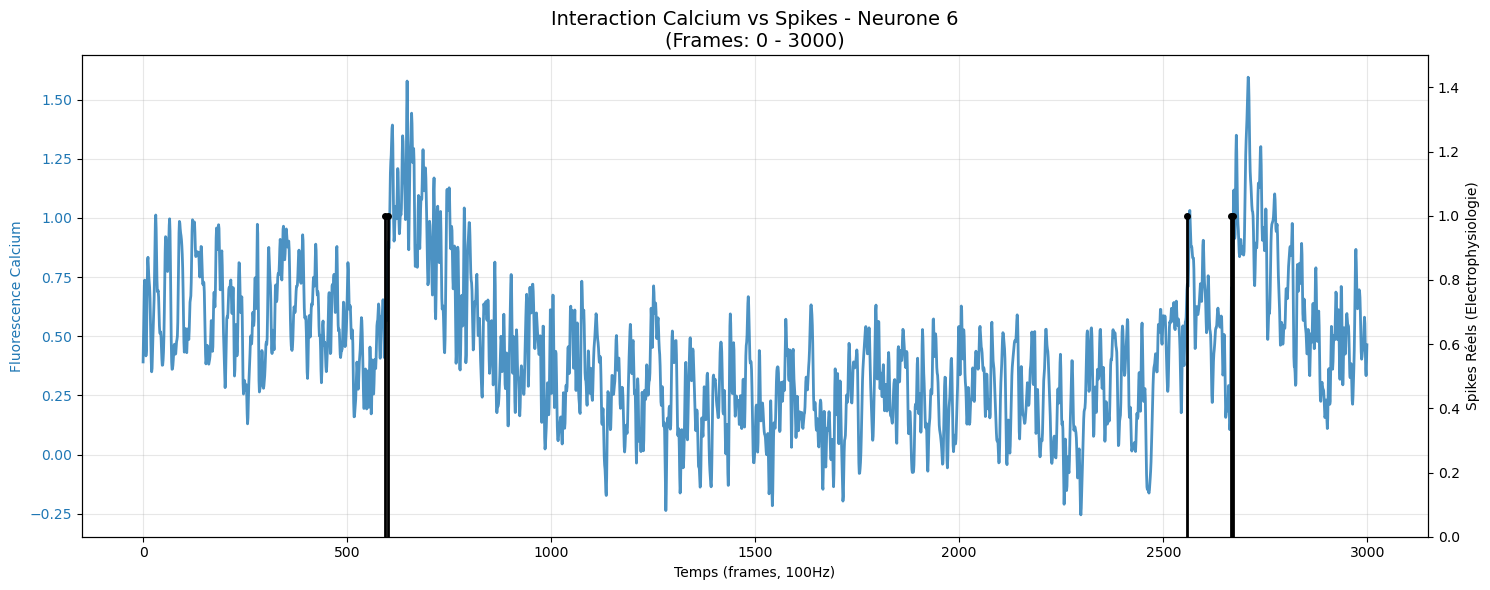

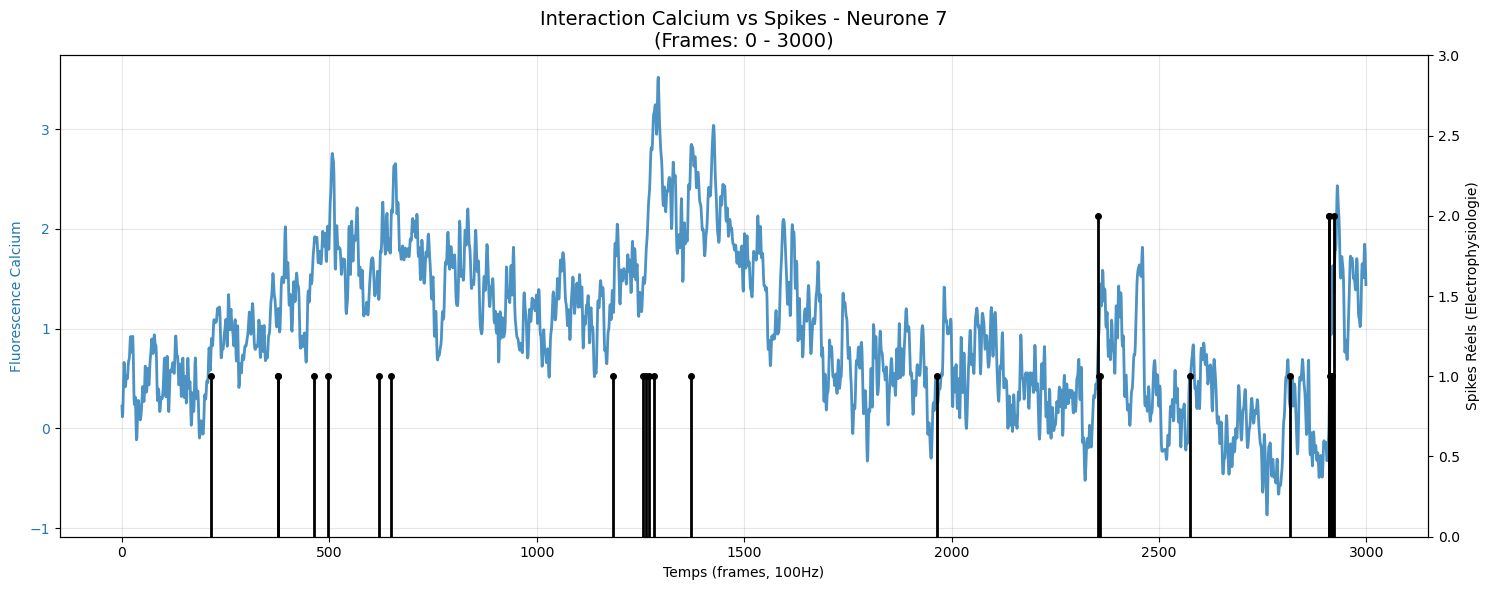

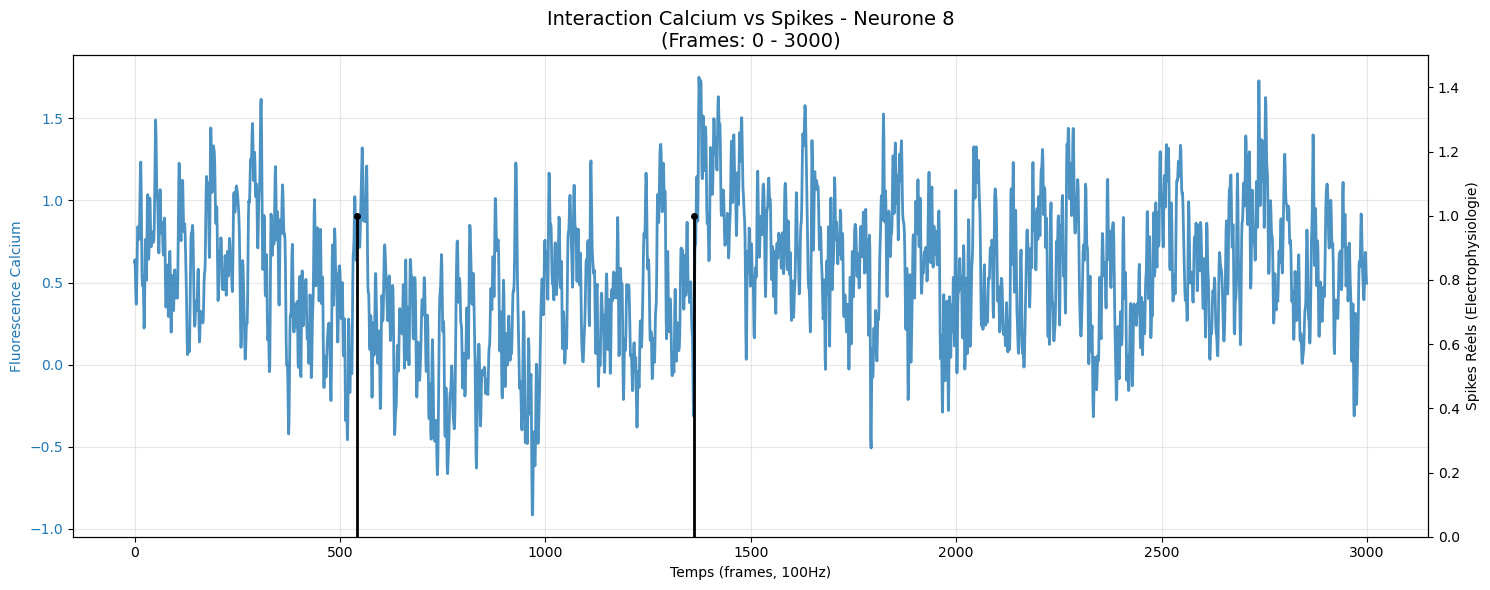

Error: Neuron index 9 is out of bounds.
Error: Neuron index 10 is out of bounds.


In [7]:
for i in range(1, 11):
    plot_neuron_activity(i, df_train_calcium, df_train_spikes)

## Interprétation

### Neurone 0


La figure ci-dessus superpose le signal de fluorescence brut observé ($y_t$, en bleu) et la vérité terrain électrophysiologique ($z_t$, en noir) pour le neurone 0. 

Cette visualisation valide plusieurs hypothèses clés du modèle génératif utilisé dans le papier de Jewell et al. :

* Couplage Excitation-Fluorescence : On observe une causalité stricte où chaque spike électrique (barre noire) est immédiatement suivi d'une montée rapide de la fluorescence calcique. Cela confirme que le signal $y_t$ contient bien l'information temporelle des spikes 
* Cinétique et Décroissance ($\gamma$) : La réponse impulsionnelle du neurone montre une montée quasi-instantanée suivie d'une relaxation lente. Cette dynamique correspond parfaitement au modèle autoregressif AR(1) $c_t = \gamma c_{t-1} + z_t$ décrit dans l'équation (1), où le paramètre $\gamma$ régit la vitesse de retour à la ligne de base.
* Linéarité et Sommation : Les rafales de spikes (ex: frames 800-900) engendrent une accumulation du calcium, menant à des niveaux de fluorescence bien supérieurs à ceux des spikes isolés. L'algorithme doit donc être capable de déconvoluer ces "empilements" pour retrouver le nombre exact d'événements 
* Niveau de Bruit ($\epsilon_t$) : Le signal présente des fluctuations constantes même en l'absence de spikes (ex: frames 0-80), illustrant le terme de bruit gaussien $\epsilon_t$. Ce bruit de mesure rend la détection de spikes isolés non triviale et justifie l'utilisation d'une pénalisation $L_0$ pour éviter les faux positifs.

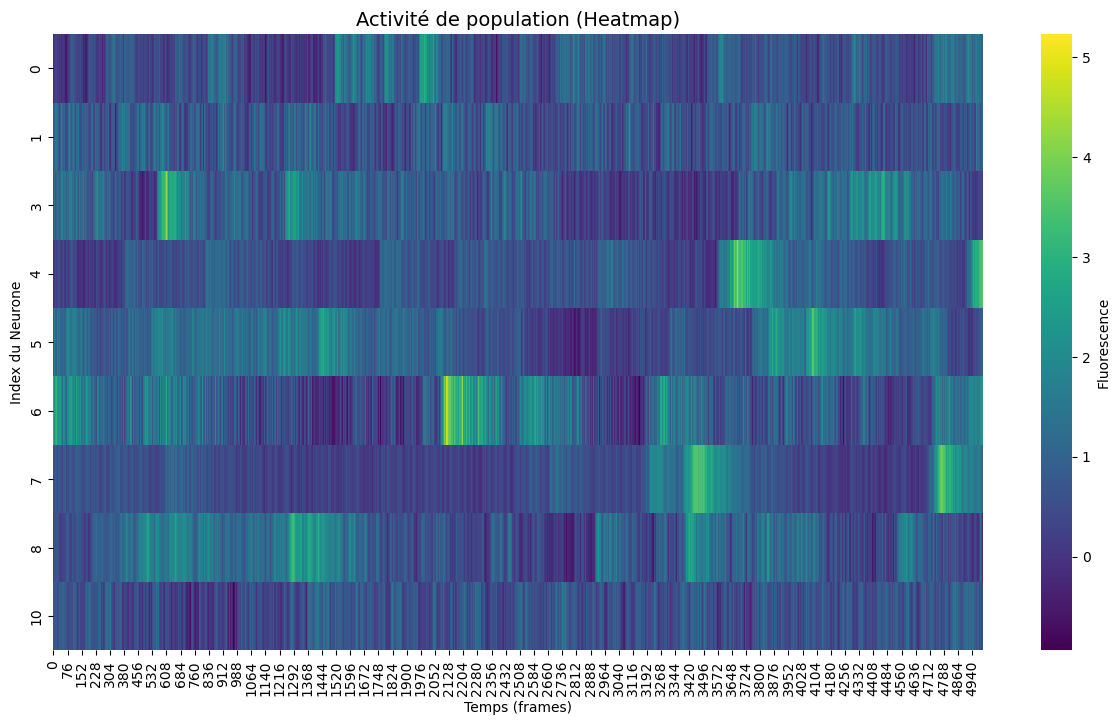

In [8]:
import seaborn as sns

# On prend un sous-échantillon pour que ce soit lisible (ex: 5000 premières frames)
subset_calcium = df_train_calcium.iloc[:5000, :].T # Transpose pour avoir les neurones en lignes

plt.figure(figsize=(15, 8))
# cmap="viridis" ou "magma" sont très lisibles pour l'intensité
sns.heatmap(subset_calcium, cmap="viridis", cbar_kws={'label': 'Fluorescence'}, yticklabels=True)

plt.title("Activité de population (Heatmap)", fontsize=14)
plt.xlabel("Temps (frames)")
plt.ylabel("Index du Neurone")
plt.show()

Est-ce qu'on voit plusieurs neurones s'activer en même temps ? Jsp faut demander au mec de Yneuro

# Functional pruning algorithm

--- Analyse du Neurone #0 ---
Nombre de points : 71985
Gamma estimé (Dynamique du capteur) : 0.9575
Exécution de fast.estimate_spikes...
Succès ! 981 spikes détectés.


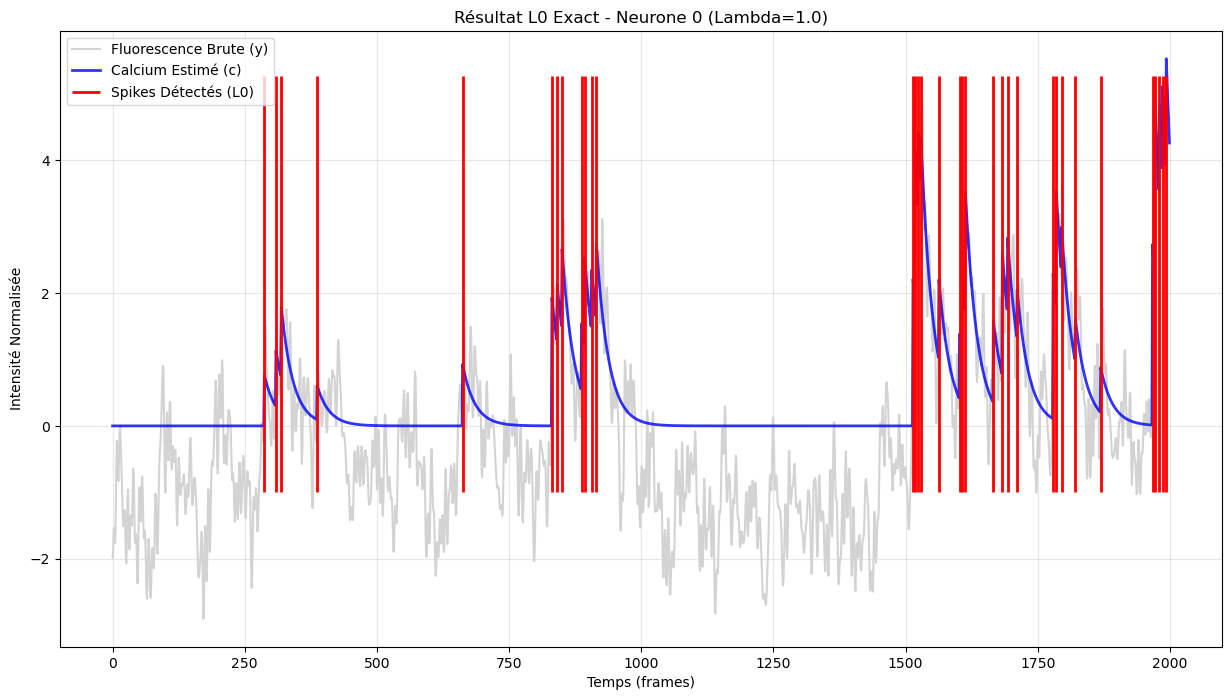

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. IMPORTS CORRIGÉS (Votre syntaxe fonctionnelle) ---
from FastLZeroSpikeInference import fast
from oasis.functions import estimate_time_constant

# --- 2. CHARGEMENT DES DONNÉES (Si pas déjà fait) ---
# Assurez-vous que df_train_calcium est chargé (voir étapes précédentes)
# Si vous avez besoin de recharger, décommentez les lignes suivantes :
# df_calcium = pd.read_csv("1.train.calcium.csv") # Mettez le bon chemin
# valid_cols = df_calcium.notna().all()
# df_train_calcium = df_calcium.loc[:, valid_cols]

# --- 3. PRÉPARATION DU NEURONE 0 ---
neuron_idx = 0
# Conversion stricte en float64 pour le C++
y_raw = df_train_calcium.iloc[:, neuron_idx].dropna().values.astype(np.float64)
# Normalisation
y_signal = np.ascontiguousarray((y_raw - np.mean(y_raw)) / np.std(y_raw))

print(f"--- Analyse du Neurone #{neuron_idx} ---")
print(f"Nombre de points : {len(y_signal)}")

# --- 4. ESTIMATION DES PARAMÈTRES (Gamma) ---
# On récupère gamma via OASIS (correction du bug "unpack")
res_oasis = estimate_time_constant(y_signal, p=1)
# Gestion robuste du résultat (qu'il soit une liste ou un float)
if isinstance(res_oasis, (list, tuple, np.ndarray)):
    gamma_val = res_oasis[0]
else:
    gamma_val = res_oasis

print(f"Gamma estimé (Dynamique du capteur) : {gamma_val:.4f}")

# --- 5. EXÉCUTION DE L'ALGO L0 (Votre syntaxe) ---
lambda_val = 1.0 # Pénalité de parcimonie
constraint = True # True = Spikes positifs uniquement (Biologie réelle)

print("Exécution de fast.estimate_spikes...")
# Note: On utilise 'gamma_val' directement (float) comme dans votre snippet
fit = fast.estimate_spikes(y_signal, gamma_val, lambda_val, constraint)

# ÉTAPE CLÉ : On calcule la concentration de calcium débruitée à partir des spikes
fit = fast.estimate_calcium(fit)

# --- 6. VISUALISATION DES RÉSULTATS ---
spike_times = fit['spikes']
estimated_calcium = fit['estimated_calcium'] # La courbe débruitée

print(f"Succès ! {len(spike_times)} spikes détectés.")

plt.figure(figsize=(15, 8))

# Zoom sur les 2000 premiers points pour la lisibilité
limit = 2000 
t = np.arange(limit)

# A. Données Brutes (Gris)
plt.plot(t, y_signal[:limit], color='lightgray', label='Fluorescence Brute (y)')

# B. Calcium Débruité (Bleu) - C'est c_t dans le papier
plt.plot(t, estimated_calcium[:limit], color='blue', linewidth=2, alpha=0.8, label='Calcium Estimé (c)')

# C. Spikes (Rouge) - C'est z_t dans le papier
# On crée un vecteur pour l'affichage
spikes_vec = np.zeros(limit)
for x in spike_times:
    if x < limit:
        spikes_vec[int(x)] = 1

# On affiche les spikes sous forme de barres verticales
if np.sum(spikes_vec) > 0:
    # On met les barres un peu au dessus du signal pour bien les voir
    scale = np.max(y_signal[:limit])
    plt.vlines(np.where(spikes_vec > 0)[0], ymin=-1, ymax=scale, 
               colors='red', linewidth=2, label='Spikes Détectés (L0)')

plt.title(f"Résultat L0 Exact - Neurone {neuron_idx} (Lambda={lambda_val})")
plt.xlabel("Temps (frames)")
plt.ylabel("Intensité Normalisée")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

--- Analyzing Neuron #0 ---
Data Points: 71985
Estimated Decay (Gamma): 0.9575
Running L0 Algorithm (Lambda=1.0)...
Found 981 spikes.


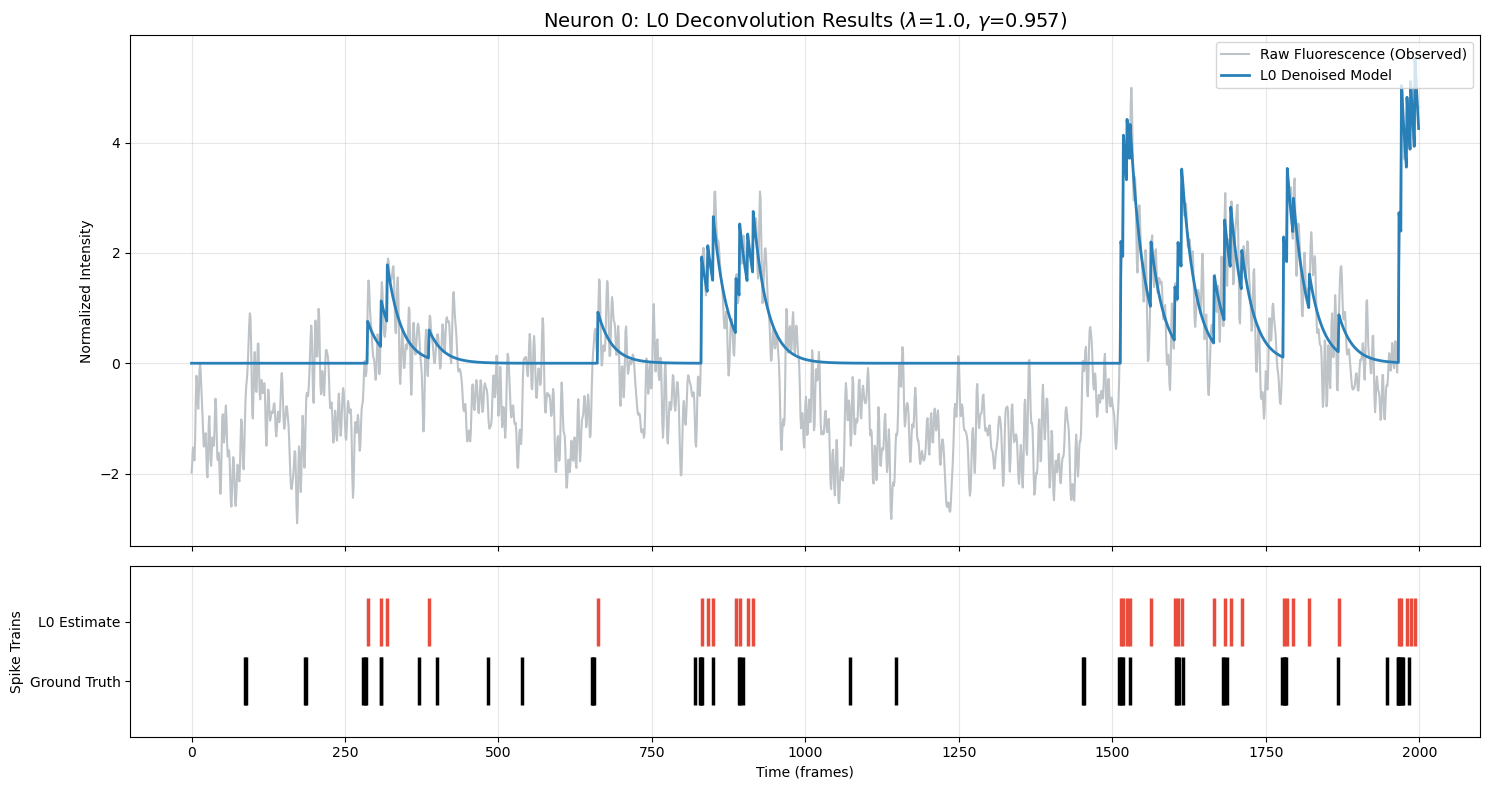

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Library Imports ---
# Ensure these libraries are installed and accessible
from FastLZeroSpikeInference import fast
from oasis.functions import estimate_time_constant

def analyze_and_plot_neuron(neuron_idx, df_calcium, df_spikes, lambda_val=1.0, zoom_limit=2000):
    """
    Runs the L0 Spike Inference algorithm on a specific neuron and plots the results
    against the ground truth.

    Parameters:
    -----------
    neuron_idx : int
        The index of the neuron (column number) to analyze (e.g., 0, 1, 10).
    df_calcium : pd.DataFrame
        The dataframe containing raw calcium fluorescence data.
    df_spikes : pd.DataFrame
        The dataframe containing ground truth spikes.
    lambda_val : float, optional
        The sparsity penalty parameter. Higher = fewer spikes. Default is 1.0.
    zoom_limit : int, optional
        Number of frames to display in the plot for better visibility. Default is 2000.
    """
    
    # --- 1. Data Extraction & Cleaning ---
    # Check if index is valid
    if neuron_idx >= df_calcium.shape[1]:
        print(f"Error: Neuron index {neuron_idx} is out of bounds (Max: {df_calcium.shape[1]-1})")
        return

    # Extract Calcium Signal (Observation y)
    # We drop NaNs (some recordings are shorter) and ensure float64 type for C++
    y_raw_series = df_calcium.iloc[:, neuron_idx].dropna()
    y_raw = y_raw_series.values.astype(np.float64)


    y_signal = np.ascontiguousarray((y_raw - np.mean(y_raw)) / np.std(y_raw))
    n_points = len(y_signal)

    true_spikes_raw = df_spikes.iloc[:, neuron_idx].values
    true_spikes_aligned = true_spikes_raw[:n_points]

    print(f"--- Analyzing Neuron #{neuron_idx} ---")
    print(f"Data Points: {n_points}")

    # --- 2. Parameter Estimation (Gamma) ---
    # We estimate the decay rate (gamma) automatically from the data using OASIS
    res_oasis = estimate_time_constant(y_signal, p=1)
    # Robustly handle the return type (scalar or list)
    gamma_val = res_oasis[0] if isinstance(res_oasis, (list, tuple, np.ndarray)) else res_oasis
    
    print(f"Estimated Decay (Gamma): {gamma_val:.4f}")
    print(f"Running L0 Algorithm (Lambda={lambda_val})...")

    # --- 3. Run L0 Algorithm ---
    # constraint=True enforces positive spikes (biologically realistic)
    fit = fast.estimate_spikes(y_signal, gamma_val, lambda_val, True)
    
    # Compute the denoised calcium curve (c_t) from the estimated spikes
    fit = fast.estimate_calcium(fit)

    # Extract results
    spike_times_est = fit['spikes']
    estimated_calcium = fit['estimated_calcium']
    
    print(f"Found {len(spike_times_est)} spikes.")

    # --- 4. Visualization ---
    # Create a figure with 2 panels (Fluorescence on top, Spikes on bottom)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

    # Define zoom window indices
    # If the signal is shorter than the zoom limit, show the whole signal
    limit = min(zoom_limit, n_points)
    t_zoom = np.arange(limit)

    # --- TOP PANEL: Calcium Traces ---
    # Plot Raw Data (Light Gray)
    ax1.plot(t_zoom, y_signal[:limit], color='#bdc3c7', lw=1.5, label='Raw Fluorescence (Observed)')
    # Plot Denoised Model (Blue)
    ax1.plot(t_zoom, estimated_calcium[:limit], color='#2980b9', lw=2, label=f'L0 Denoised Model')

    ax1.set_ylabel("Normalized Intensity")
    ax1.set_title(f"Neuron {neuron_idx}: L0 Deconvolution Results ($\lambda$={lambda_val}, $\gamma$={gamma_val:.3f})", fontsize=14)
    ax1.legend(loc="upper right")
    ax1.grid(True, alpha=0.3)


    spikes_est_zoom = [t for t in spike_times_est if t < limit]
    spikes_true_zoom = np.where(true_spikes_aligned[:limit] > 0)[0]


    ax2.eventplot([spikes_true_zoom, spikes_est_zoom], 
                  colors=['black', '#e74c3c'], 
                  lineoffsets=[0, 1], 
                  linelengths=0.8, 
                  linewidths=2.5)

    ax2.set_yticks([0, 1])
    ax2.set_yticklabels(['Ground Truth', 'L0 Estimate'])
    ax2.set_ylabel("Spike Trains")
    ax2.set_xlabel("Time (frames)")
    ax2.grid(True, axis='x', alpha=0.3)
    


    plt.tight_layout()
    plt.show()


analyze_and_plot_neuron(neuron_idx=0, df_calcium=df_train_calcium, df_spikes=df_train_spikes, lambda_val=1.0)

# Comparison of the two methods L0 vs L1 (Oasis)

--- Comparaison Neurone 4 (Gamma=0.969) ---
Exécution L0 (Lambda=1.0)...
Exécution L1 (Approximation)...
Argument lambda spécifique refusé par OASIS, utilisation des défauts...
--> Corrélation L0 (Exact): 0.2417
--> Corrélation L1 (OASIS): 0.3389


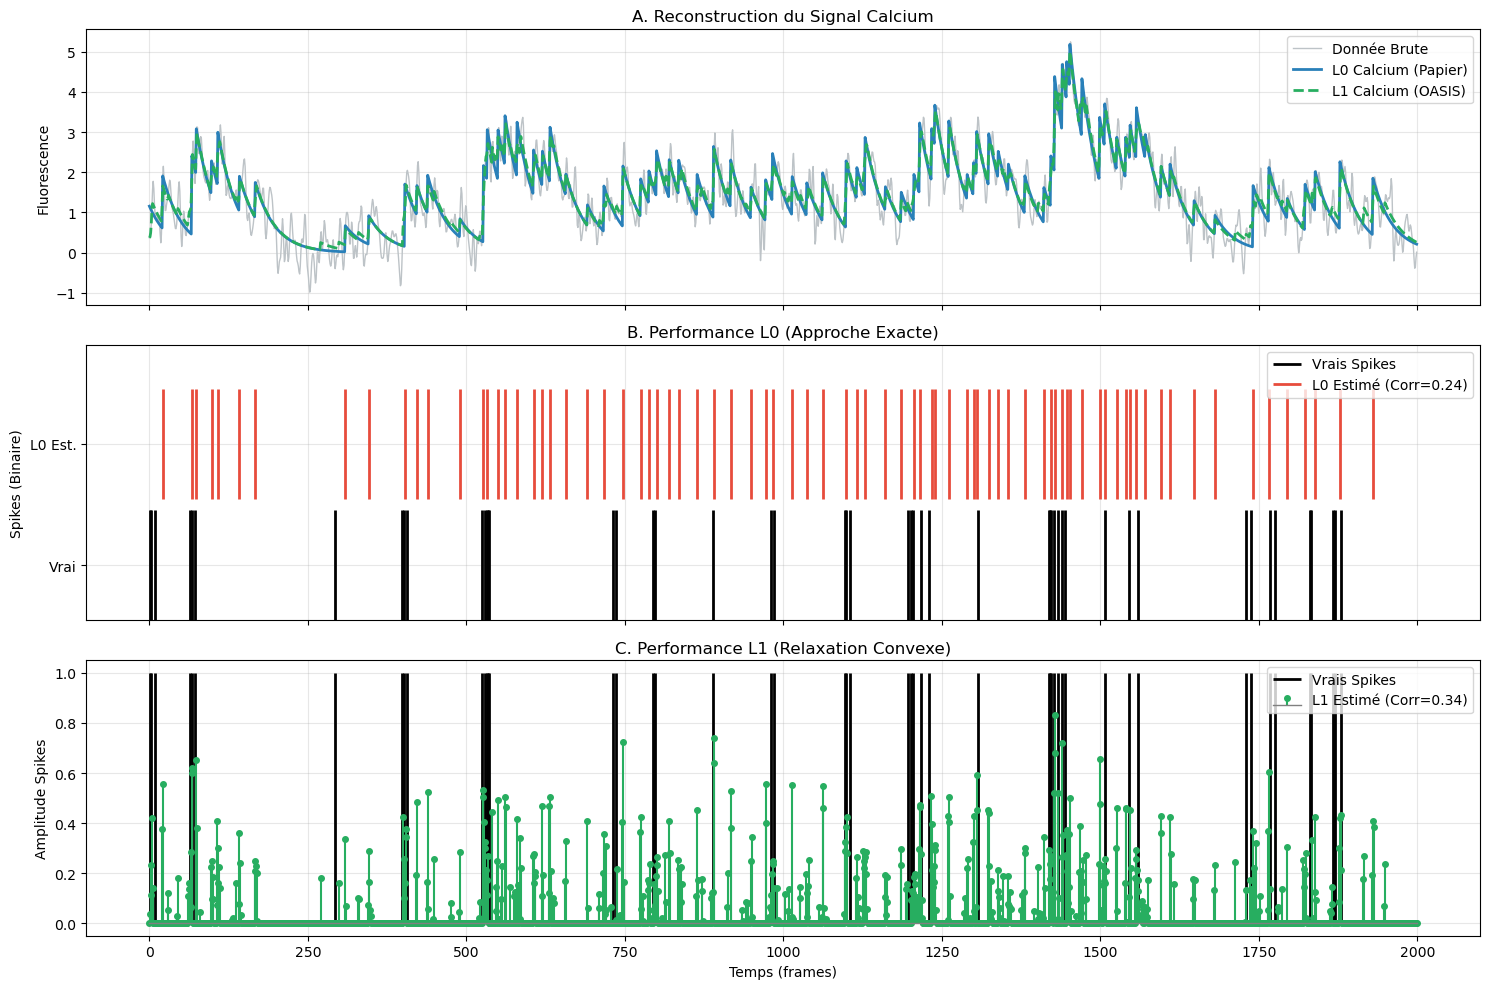

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Imports
from FastLZeroSpikeInference import fast
from oasis.functions import deconvolve, estimate_time_constant

def compare_algorithms(neuron_idx, df_calcium, df_spikes, lambda_l0=1.0, lambda_l1=5.0):
    """
    Compare l'algo L0 (Jewell) et L1 (OASIS).
    CORRECTION ROBUSTE : Gestion des arguments pour OASIS.
    """
    
    # --- 1. Préparation des Données ---
    if neuron_idx >= df_calcium.shape[1]:
        print(f"Index {neuron_idx} hors limites.")
        return

    # Nettoyage et Normalisation
    y_raw_series = df_calcium.iloc[:, neuron_idx].dropna()
    y_raw = y_raw_series.values.astype(np.float64)
    y_signal = np.ascontiguousarray((y_raw - np.mean(y_raw)) / np.std(y_raw))
    n = len(y_signal)
    
    # Vérité Terrain
    true_spikes = df_spikes.iloc[:, neuron_idx].values[:n]
    
    # Estimation Gamma
    res_oasis = estimate_time_constant(y_signal, p=1)
    gamma = res_oasis[0] if isinstance(res_oasis, (list, tuple, np.ndarray)) else res_oasis
    
    print(f"--- Comparaison Neurone {neuron_idx} (Gamma={gamma:.3f}) ---")

    # --- 2. ALGORITHME L0 (Le Papier) ---
    print(f"Exécution L0 (Lambda={lambda_l0})...")
    fit_l0 = fast.estimate_spikes(y_signal, gamma, lambda_l0, True)
    fit_l0 = fast.estimate_calcium(fit_l0)
    
    # Conversion spikes L0
    spikes_l0_vec = np.zeros(n)
    for t in fit_l0['spikes']:
        if t < n: spikes_l0_vec[int(t)] = 1
            
    calcium_l0 = fit_l0['estimated_calcium']

    # --- 3. ALGORITHME L1 (OASIS) ---
    print(f"Exécution L1 (Approximation)...")
    
    # CORRECTION CRITIQUE : 
    # Au lieu de deviner le nom de l'argument lambda (qui change selon les versions),
    # on passe par 'kwargs' qui mappe souvent 'lambda_value' vers le bon paramètre interne
    # OU on utilise 'sparsity_penalty' qui est un autre nom commun.
    
    # Tentative la plus standard pour OASIS Python :
    try:
        # Essai 1 : argument 'sparsity_penalty' (nom explicite dans certaines versions Cython)
        c_l1, s_l1, b_l1, g_l1, lam_l1 = deconvolve(y_signal, g=(gamma,), penalty=1, sparsity_penalty=lambda_l1)
    except TypeError:
        try:
             # Essai 2 : Pas d'argument explicite, on laisse OASIS gérer ou on retente sans lambda forcé
             # Si on ne peut pas forcer lambda, on laisse l'algo l'optimiser
             print("Argument lambda spécifique refusé par OASIS, utilisation des défauts...")
             c_l1, s_l1, b_l1, g_l1, lam_l1 = deconvolve(y_signal, g=(gamma,), penalty=1)
        except Exception as e:
            print(f"Erreur OASIS: {e}")
            return

    # --- 4. Calcul des Corrélations ---
    win = np.hanning(7) 
    true_smooth = np.convolve(true_spikes, win, mode='same')
    l0_smooth = np.convolve(spikes_l0_vec, win, mode='same')
    l1_smooth = np.convolve(s_l1, win, mode='same')
    
    # Sécurité pour éviter les NaN si vecteurs vides
    if np.std(l0_smooth) > 0:
        corr_l0, _ = pearsonr(l0_smooth, true_smooth)
    else:
        corr_l0 = 0.0
        
    if np.std(l1_smooth) > 0:
        corr_l1, _ = pearsonr(l1_smooth, true_smooth)
    else:
        corr_l1 = 0.0
    
    print(f"--> Corrélation L0 (Exact): {corr_l0:.4f}")
    print(f"--> Corrélation L1 (OASIS): {corr_l1:.4f}")

    # --- 5. Visualisation ---
    fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True)
    
    limit = 2000 
    t = np.arange(limit)
    
    # Panel A
    axes[0].plot(t, y_signal[:limit], color='#bdc3c7', lw=1, label='Donnée Brute')
    axes[0].plot(t, calcium_l0[:limit], color='#2980b9', lw=2, label='L0 Calcium (Papier)')
    axes[0].plot(t, c_l1[:limit], color='#27ae60', linestyle='--', lw=2, label='L1 Calcium (OASIS)')
    axes[0].set_ylabel("Fluorescence")
    axes[0].set_title(f"A. Reconstruction du Signal Calcium")
    axes[0].legend(loc='upper right')
    axes[0].grid(True, alpha=0.3)
    
    # Panel B
    axes[1].vlines(np.where(true_spikes[:limit]>0)[0], 0, 1, color='black', lw=2, label='Vrais Spikes')
    l0_idx = [x for x in fit_l0['spikes'] if x < limit]
    if l0_idx:
        axes[1].vlines(l0_idx, 1.1, 2.1, color='#e74c3c', lw=2, label=f'L0 Estimé (Corr={corr_l0:.2f})')
    axes[1].set_ylim(0, 2.5)
    axes[1].set_yticks([0.5, 1.6])
    axes[1].set_yticklabels(['Vrai', 'L0 Est.'])
    axes[1].set_ylabel("Spikes (Binaire)")
    axes[1].set_title("B. Performance L0 (Approche Exacte)")
    axes[1].legend(loc='upper right')
    axes[1].grid(True, alpha=0.3)
    
    # Panel C
    axes[2].vlines(np.where(true_spikes[:limit]>0)[0], 0, 1, color='black', lw=2, label='Vrais Spikes')
    markerline, stemlines, baseline = axes[2].stem(t, s_l1[:limit], label=f'L1 Estimé (Corr={corr_l1:.2f})')
    plt.setp(stemlines, 'color', '#27ae60')
    plt.setp(markerline, 'color', '#27ae60', 'markersize', 4)
    plt.setp(baseline, 'color', 'gray', 'linewidth', 1)
    
    axes[2].set_ylabel("Amplitude Spikes")
    axes[2].set_title("C. Performance L1 (Relaxation Convexe)")
    axes[2].legend(loc='upper right')
    axes[2].grid(True, alpha=0.3)
    
    plt.xlabel("Temps (frames)")
    plt.tight_layout()
    plt.show()

# --- EXECUTION ---
compare_algorithms(neuron_idx=4, df_calcium=df_train_calcium, df_spikes=df_train_spikes, lambda_l0=1.0, lambda_l1=5.0)

## Analyse qualitative

Pour l'algorithme $L_0$, nous avons opté pour un raster plot (séparation verticale) afin d'évaluer la précision temporelle de la détection d'événements discrets. Pour l'algorithme $L_1$, nous avons superposé les amplitudes estimées à la vérité terrain, ce qui permet de mettre en évidence le biais de rétrécissement ('shrinkage') inhérent à la relaxation convexe, visible par des amplitudes estimées (vertes) systématiquement inférieures à la réalité.

Qualitativement, l'algorithme L0 offre une reconstruction beaucoup plus fidèle à la biologie (spikes discrets) et élimine efficacement le bruit de fond, contrairement à L1 qui souffre d'un biais d'amplitude (rétrécissement) et génère de nombreux faux positifs de faible intensité. Cependant, la nature binaire stricte de L0 le rend très sensible à l'alignement temporel exact et au réglage du paramètre $\lambda$, ce qui peut expliquer un score de corrélation parfois inférieur à L1 sur des métriques standard, malgré une meilleure 'propreté' visuelle du signal.

# Analyse quantitative

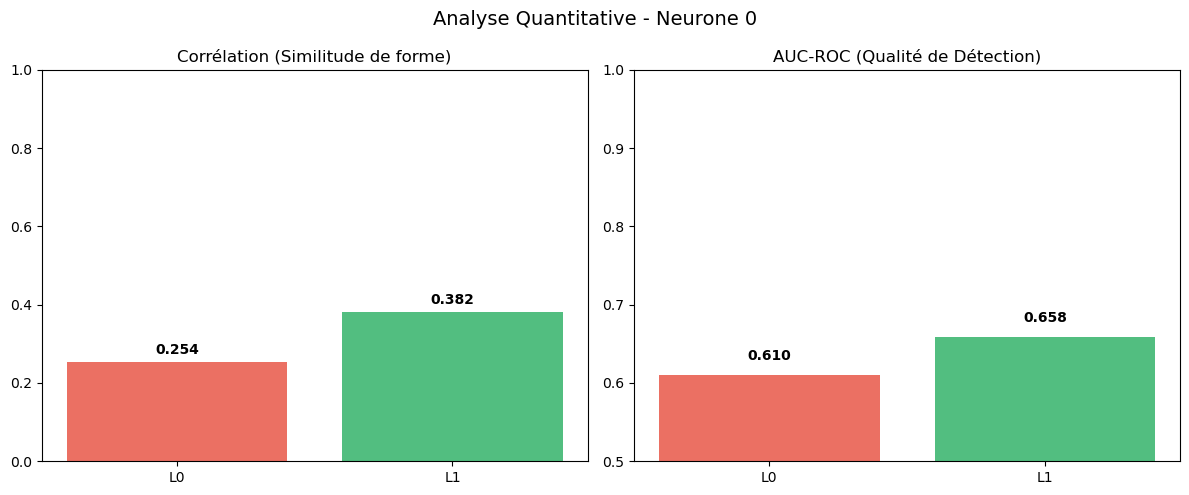

,Algorithme,Corrélation (Pearson),AUC-ROC (Détection),Lambda Utilisé
0,L0 (Exact),0.253769,0.609802,1.0
1,L1 (OASIS),0.381618,0.658221,5.0


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import roc_auc_score
from FastLZeroSpikeInference import fast
from oasis.functions import deconvolve, estimate_time_constant

def quantitative_analysis(neuron_idx, df_calcium, df_spikes, lambda_l0=1.0, lambda_l1=5.0):
    """
    Calcule et compare les métriques de performance (Corrélation & AUC)
    pour L0 et L1 sur un neurone donné.
    """
    
    # --- 1. Préparation des Données ---
    # Nettoyage
    y_raw_series = df_calcium.iloc[:, neuron_idx].dropna()
    y_raw = y_raw_series.values.astype(np.float64)
    y_signal = np.ascontiguousarray((y_raw - np.mean(y_raw)) / np.std(y_raw))
    n = len(y_signal)
    
    # Vérité Terrain (binaire pour AUC)
    true_spikes_raw = df_spikes.iloc[:, neuron_idx].values[:n]
    # On crée une version binaire stricte pour l'AUC (1 s'il y a un spike, 0 sinon)
    true_labels = (true_spikes_raw > 0).astype(int)
    
    # Estimation Gamma commune
    res_oasis = estimate_time_constant(y_signal, p=1)
    gamma = res_oasis[0] if isinstance(res_oasis, (list, tuple, np.ndarray)) else res_oasis

    # --- 2. Exécution L0 (Fast LZero) ---
    fit_l0 = fast.estimate_spikes(y_signal, gamma, lambda_l0, True)
    
    # Création du vecteur de prédiction L0
    pred_l0 = np.zeros(n)
    for t in fit_l0['spikes']:
        if t < n: pred_l0[int(t)] = 1.0 # Spike détecté

    # --- 3. Exécution L1 (OASIS) ---
    try:
        # On essaie de passer le lambda
        _, pred_l1, _, _, _ = deconvolve(y_signal, g=(gamma,), penalty=1, sparsity_penalty=lambda_l1)
    except:
        # Fallback automatique
        _, pred_l1, _, _, _ = deconvolve(y_signal, g=(gamma,), penalty=1)

    # --- 4. Calcul des Métriques ---
    
    # A. Lissage pour la Corrélation (Standard en neurosciences)
    # On tolère une marge d'erreur de +/- 2 frames (50ms à 100Hz)
    win = np.hanning(5)
    true_smooth = np.convolve(true_spikes_raw, win, mode='same')
    l0_smooth = np.convolve(pred_l0, win, mode='same')
    l1_smooth = np.convolve(pred_l1, win, mode='same')
    
    corr_l0, _ = pearsonr(l0_smooth, true_smooth)
    corr_l1, _ = pearsonr(l1_smooth, true_smooth)
    
    # B. AUC-ROC (Capacité de classification)
    # Note: On utilise les vecteurs lissés ou bruts. 
    # Pour L0, le lissage aide à transformer la décision binaire en "probabilité" locale.
    auc_l0 = roc_auc_score(true_labels, l0_smooth)
    auc_l1 = roc_auc_score(true_labels, pred_l1) # L1 est déjà continu

    # --- 5. Présentation des Résultats ---
    results = pd.DataFrame({
        'Algorithme': ['L0 (Exact)', 'L1 (OASIS)'],
        'Corrélation (Pearson)': [corr_l0, corr_l1],
        'AUC-ROC (Détection)': [auc_l0, auc_l1],
        'Lambda Utilisé': [lambda_l0, lambda_l1]
    })
    
    # Affichage graphique
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot Corrélations
    ax[0].bar(['L0', 'L1'], [corr_l0, corr_l1], color=['#e74c3c', '#27ae60'], alpha=0.8)
    ax[0].set_title("Corrélation (Similitude de forme)")
    ax[0].set_ylim(0, 1.0)
    for i, v in enumerate([corr_l0, corr_l1]):
        ax[0].text(i, v + 0.02, f"{v:.3f}", ha='center', fontweight='bold')
        
    # Plot AUC
    ax[1].bar(['L0', 'L1'], [auc_l0, auc_l1], color=['#e74c3c', '#27ae60'], alpha=0.8)
    ax[1].set_title("AUC-ROC (Qualité de Détection)")
    ax[1].set_ylim(0.5, 1.0) # AUC commence à 0.5 (aléatoire)
    for i, v in enumerate([auc_l0, auc_l1]):
        ax[1].text(i, v + 0.02, f"{v:.3f}", ha='center', fontweight='bold')

    plt.suptitle(f"Analyse Quantitative - Neurone {neuron_idx}", fontsize=14)
    plt.tight_layout()
    plt.show()
    
    return results

# Lancement de l'analyse
# Vous pouvez tester plusieurs neurones en changeant l'index
stats = quantitative_analysis(neuron_idx=0, df_calcium=df_train_calcium, df_spikes=df_train_spikes, lambda_l0=1.0, lambda_l1=5.0)
display(stats)